In [206]:
%matplotlib inline
import numpy as np
import random
import itertools
import os
import glob
import math
import time
import multiprocessing as mp
print('CPU:', mp.cpu_count())

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('ytick', labelsize=25)
rc('xtick', labelsize=25)

from ipywidgets import interactive
import ipywidgets as widgets

CPU: 4


In [307]:
def dist(v1, v2):
    
    return np.sqrt((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2)


def initializePositions(L, N, s):
    """
    Generate a N particles with radius s 
    in box size L that do not overlap
    """
    
    x0, y0 = [], []
    x0.append(np.random.uniform(s,L-s))
    y0.append(np.random.uniform(s,L-s))

    for i in range(1,N):

        K = len(x0)
        collision = [True for i in range(K)]

        while True in collision:
            xi_prop = np.random.uniform(s,L-s)
            yi_prop = np.random.uniform(s,L-s)

            for k in range(K):

                d = dist((x0[k], y0[k]), (xi_prop, yi_prop))
                if d < 2*s:
                    collision[k] = True
                else:
                    collision[k] = False

        x0.append(xi_prop)
        y0.append(yi_prop)
        
    return np.array(x0), np.array(y0)


def initializeVelocities(E, m, N):
    
    vtot = np.sqrt(2*E/m) * np.ones(N)
    
    # Initialize velocity magnitudes
    v0 = np.array([np.random.uniform(0,v) for v in vtot])
    u0 = np.sqrt(vtot**2 - v0**2)

    # add sign to component to velocities
    v0 = np.random.choice([-1,1], N) * v0
    u0 = np.random.choice([-1,1], N) * u0
    
    return v0, u0

In [446]:
def runSimulation(x0, y0, v0, u0, m, T, s, L):
    
    N = len(x0)
    pos_x, pos_y = [x0], [y0]
    vel_x, vel_y = [v0], [u0]

    for t in range(T): #iterate over time-step
        
        x_curr, y_curr = pos_x[-1], pos_y[-1]
        v_curr, u_curr = vel_x[-1], vel_y[-1]
        
        x_new, y_new = np.zeros(N), np.zeros(N)
        v_new, u_new = np.zeros(N), np.zeros(N)

        # ================================
        # Advance particle positions
        # ================================
        for i in range(N): #iterate over each particle
    
            xprop_i = x_curr[i] + v_curr[i] * dt
            yprop_i = y_curr[i] + u_curr[i] * dt    
           
            # ================================
            # Check for particle-wall collisions
            # ================================
            if xprop_i < s:   # left wall
                v_new[i] = -v_curr[i]

            elif xprop_i > L-s:   # right wall
                v_new[i] = -v_curr[i]

            else:
                v_new[i] = v_curr[i]

            if yprop_i < s:   # bottom wall
                u_new[i] = -u_curr[i]

            elif yprop_i > L-s:   # top wall
                u_new[i] = -u_curr[i]

            else:
                u_new[i] = u_curr[i]
                
            x_new[i] = xprop_i
            y_new[i] = yprop_i

            
        # ================================
        # Check for particle-particle collisions
        # ================================
        
        # Iterate over all (N choose 2) combinations of particle pairs
        perm = list(itertools.combinations(range(N), 2))
        
        for p in perm:
            
            i, j = p
            separation = np.sqrt((x_new[i] - x_new[j])**2 + (y_new[i] - y_new[j])**2)
            
            if separation < 2*s:

                v_new[i] = ((m[i] - m[j])/(m[i] + m[j])*v_curr[i] + (2*m[j])/(m[i] + m[j])*v_curr[j])
                v_new[j] = ((m[j] - m[i])/(m[i] + m[j])*v_curr[j] + (2*m[i])/(m[i] + m[j])*v_curr[i])
                
                u_new[i] = ((m[i] - m[j])/(m[i] + m[j])*u_curr[i] + (2*m[j])/(m[i] + m[j])*u_curr[j])
                u_new[j] = ((m[j] - m[i])/(m[i] + m[j])*u_curr[j] + (2*m[i])/(m[i] + m[j])*u_curr[i])
        
        pos_x.append(x_new)
        pos_y.append(y_new) 

        vel_x.append(v_new)
        vel_y.append(u_new)  
        
    return np.array(pos_x), np.array(pos_y), np.array(vel_x), np.array(vel_y)

In [294]:
def plotParticles(x, y, **kwargs):    

    fig, ax = plt.subplots(figsize=[10,10])
    
    circles = []
    for i in range(N):
        if 'm' in kwargs:
            circle = plt.Circle((x[i], y[i]), radius=s)
            circles.append(circle)
        else:
            circle = plt.Circle((x[i], y[i]), radius=s, color='r')
            ax.add_artist(circle)
        
    if 'm' in kwargs:
        m = kwargs.get('m')
        crng = kwargs.get('crng', [.01,10])
        p = PatchCollection(circles, cmap='Blues', edgecolor='none', \
                            norm=colors.LogNorm(vmin=crng[0], vmax=crng[1]))
        p.set_array(m)
        ax.add_collection(p)
        fig.colorbar(p, ax=ax, fraction=0.046, pad=0.04)
        
    if ('v' in kwargs) and ('u' in kwargs):
        v = kwargs.get('v')
        u = kwargs.get('u')
        for i in range(N):
            ax.arrow(x[i], y[i], v[i], u[i], head_width=.8, head_length=1, fc='k', ec='k')

    ax.set_aspect('equal', 'box')
    plt.xlim(0,L)
    plt.ylim(0,L)
    if 't' in kwargs:
        plt.title(r"$T=%s$"%(kwargs.get('t')), fontsize=30)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.close()
    
    return fig

## Run Simulation

In [457]:
E = 1    # energy
N = 100    # number of particles
s = 2    # particle radius
L = 100   # box length
T = 10**5   # number of time steps
dt = .001   # time step

# m = 1    # mass
m0 = 1
m = np.random.choice([m0,10*m0], N, p=[.5,.5])

x0, y0 = initializePositions(L, N, s)
v0, u0 = initializeVelocities(E, m, N)

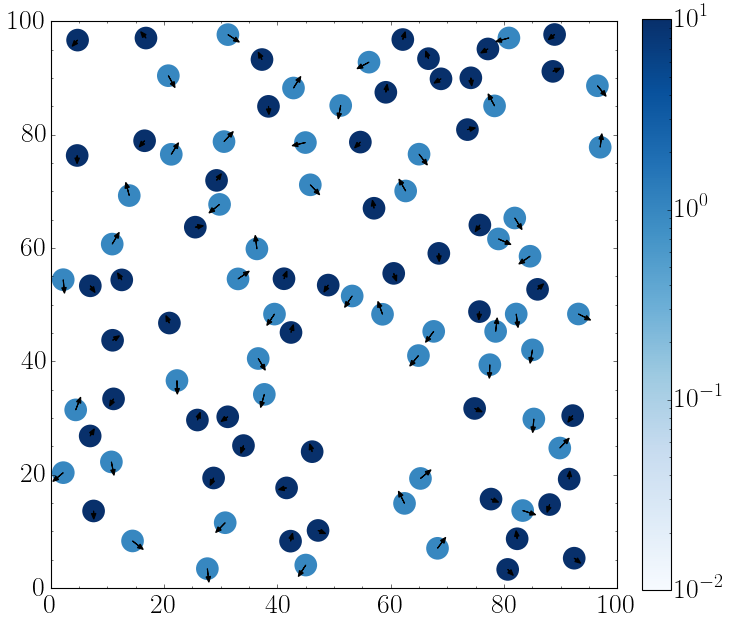

In [458]:
plotParticles(x0, y0, v=v0, u=u0, m=m, crng=[.01,10])

In [ ]:
t0 = time.time()
pos_x, pos_y, vel_x, vel_y = runSimulation(x0, y0, v0, u0, m, T, s, L)
print(time.time() - t0)
print((time.time() - t0)/60)

### Plot and Animate

In [456]:
for f in glob.glob('plots/*'):
    os.system(f'rm {f}')

def plotSeries(t):
    # pl = plotParticles(pos_x[t], pos_y[t], t=t, save=f'plots/t{t}.png')
    pl = plotParticles(pos_x[t], pos_y[t], v=vel_x[t], u=vel_y[t], m=m, crng=[.01,10], t=t, save=f'plots/t{t}.png')
    
tvals = np.arange(0,T,100)
print(f'Generating {len(tvals)} plots...')
pool = mp.Pool(mp.cpu_count())  

t0 = time.time()
result = pool.map(plotSeries, tvals)
print(time.time() - t0)

Generating 100 plots...
34.19876432418823


In [142]:
ordered_plots = ' '.join([f'plots/t{i}.png' for i in tvals])
os.system(f'convert -delay 0 -loop 10 {ordered_plots} animation.gif')

0

In [324]:
def plot_interact(t=0):    
    
    return plotParticles(pos_x[t], pos_y[t], u=vel_x[t], v=vel_y[t])

interactive_plot = interactive(plot_interact, t=(0,T,50))
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

interactive(children=(IntSlider(value=0, description='t', max=1000, step=50), Output(layout=Layout(height='700…